<a href="https://colab.research.google.com/github/thisissepehr/image-classification-deep-models/blob/main/resNet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import time
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import torch.nn.functional as F
import cv2

from torchvision import datasets
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary

1.11.0+cu113


In [2]:
# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"
GRAYSCALE = True

torch.manual_seed(RANDOM_SEED)

In [3]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    ])


train_ds = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transform_train,
                               download=True)
train_set, val_set = torch.utils.data.random_split(train_ds, [50000, 10000])

test_ds = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transform_test)


train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                      shuffle = True)


val_loader = DataLoader(dataset=val_set,
                          batch_size=BATCH_SIZE,
                      shuffle = False)

test_loader = DataLoader(dataset=test_ds,
                     batch_size=BATCH_SIZE,
                     shuffle = False)

# Checking the dataset
images, labels = next(iter(train_loader))  
print('Image batch dimensions:', images.shape)
print('Image label dimensions:', labels.shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


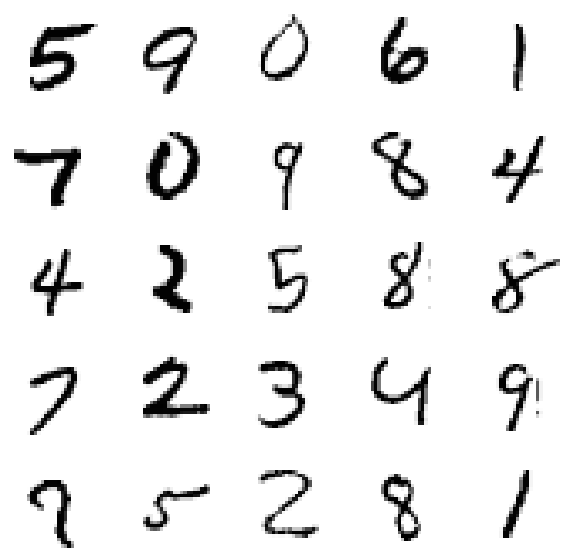

In [4]:
features, targets = next(iter(train_loader))

features = features
targets = targets
fig ,ax = plt.subplots(5,5, figsize=(10, 10))
for index in range(25):
    ax[index//5][index%5].imshow(features[index].numpy().squeeze(axis=0), cmap='Greys')
    ax[index//5][index%5].axis('off')

In [16]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.expansion = 4
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.conv3 = torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = torch.nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = torch.nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class resNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(resNet, self).__init__()

        self.in_channels = 64
        self.expansion = 4
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers=3, channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers=4, channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers=6, channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers=3, channels=512, stride=2)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, channels, stride):
        layers = []
        identity_downsample = torch.nn.Sequential(
            torch.nn.Conv2d(self.in_channels, channels*self.expansion, kernel_size=1, stride=stride),
            torch.nn.BatchNorm2d(channels*self.expansion)
            )
        layers.append(Block(self.in_channels, channels, identity_downsample, stride))
        self.in_channels = channels * self.expansion
        for _ in range(num_layers-1):
            layers.append(Block(self.in_channels, channels))
        return torch.nn.Sequential(*layers)

In [22]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_predictions, counter = 0, 0
        for _, (img, label) in enumerate(data_loader):
            img = img.to(device)
            label = label.float().to(device)
            logits = model(img)
            _, predicted_label = torch.max(logits, 1)
            counter += label.size(0)
            correct_predictions += (predicted_label == label).sum()
    return correct_predictions.float()/counter * 100

In [23]:
def init_weights(m):
    if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            m.bias.detach().zero_()

In [24]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = resNet(10)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model = model.to(DEVICE)

In [25]:
def train(model, num_epochs, train_loader,valid_loader, test_loader, optimizer):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in tqdm(enumerate(train_loader), total= len(train_loader)):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
            train_acc = accuracy(model, train_loader, device=DEVICE)
            valid_acc = accuracy(model, valid_loader, device=DEVICE)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')        
    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    test_acc = accuracy(model, test_loader, device=DEVICE)
    print(f'Test accuracy {test_acc :.2f}%')

In [26]:
train(model= model,
      num_epochs = NUM_EPOCHS,
      train_loader= train_loader,
      valid_loader = val_loader,
      test_loader = test_loader,
      optimizer = optimizer)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 001/010 | Train: 96.79% | Validation: 95.08%
Time elapsed: 0.58 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 002/010 | Train: 98.81% | Validation: 97.12%
Time elapsed: 1.16 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 003/010 | Train: 99.34% | Validation: 97.79%
Time elapsed: 1.74 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 004/010 | Train: 99.14% | Validation: 97.50%
Time elapsed: 2.33 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 005/010 | Train: 98.61% | Validation: 96.84%
Time elapsed: 2.90 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 006/010 | Train: 99.26% | Validation: 97.81%
Time elapsed: 3.48 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 007/010 | Train: 99.71% | Validation: 98.33%
Time elapsed: 4.05 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 008/010 | Train: 99.46% | Validation: 97.96%
Time elapsed: 4.62 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 009/010 | Train: 99.32% | Validation: 98.05%
Time elapsed: 5.20 min


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 010/010 | Train: 99.36% | Validation: 98.10%
Time elapsed: 5.78 min
Total Training Time: 5.78 min
Test accuracy 98.29%


In [27]:

def get_prediction(x, model):
    model.to('cpu') # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [28]:
true_y, pred_y = [], []
for batch in tqdm(iter(test_loader), total=len(test_loader)):
    x, y = batch
    true_y.extend(y)
    #print(type(x))
    preds, probs = get_prediction(x, model)
    pred_y.extend(preds.cpu())

  0%|          | 0/79 [00:00<?, ?it/s]

In [29]:
print(classification_report(true_y, pred_y, digits=3))


              precision    recall  f1-score   support

           0      0.982     0.993     0.987       980
           1      0.996     0.989     0.992      1135
           2      0.964     0.995     0.979      1032
           3      0.990     0.981     0.986      1010
           4      0.980     0.983     0.981       982
           5      0.986     0.981     0.984       892
           6      0.986     0.983     0.985       958
           7      0.980     0.985     0.983      1028
           8      0.980     0.975     0.978       974
           9      0.984     0.962     0.973      1009

    accuracy                          0.983     10000
   macro avg      0.983     0.983     0.983     10000
weighted avg      0.983     0.983     0.983     10000



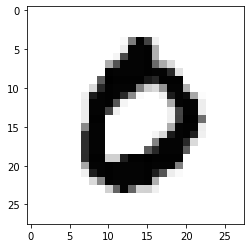

In [30]:
features, targets = next(iter(test_loader))    
nhwc_img = np.transpose(features[3], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')


In [31]:
predicted, probability = get_prediction(features[3, None], model)
print('Predicted:', predicted)
print('Probability:', probability[0][predicted]*100)

Predicted: tensor([0])
Probability: tensor([100.], grad_fn=<MulBackward0>)


In [32]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    fig, ax = plt.subplots(figsize=(16,16))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 973    0    1    0    0    0    2    3    1    0]
 [   0 1122    2    3    1    0    1    1    5    0]
 [   1    0 1027    0    0    0    0    4    0    0]
 [   0    0    7  991    0    8    0    2    2    0]
 [   0    0    6    0  965    0    4    0    0    7]
 [   2    0    0    4    1  875    5    2    1    2]
 [   7    3    1    0    2    1  942    0    2    0]
 [   0    0    3    2    4    0    0 1013    0    6]
 [   6    1   11    0    2    1    0    2  950    1]
 [   2    0    7    1   10    2    1    7    8  971]]


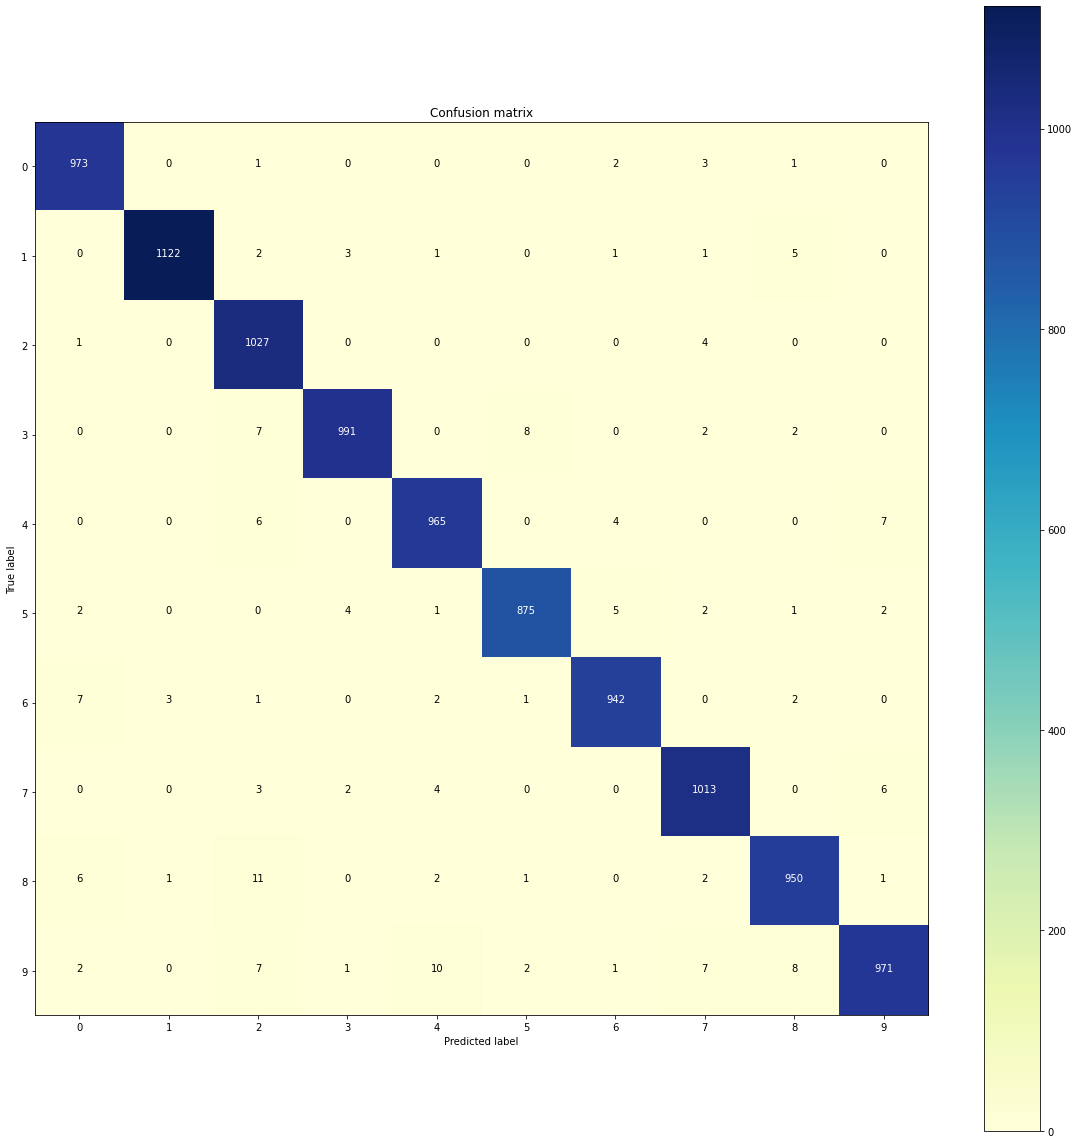

In [33]:
cm = confusion_matrix(true_y, pred_y)
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm,labels)